In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:
data = np.load('board_grade.npy', allow_pickle=True)

In [4]:
x, y = data[:, 1], data[:, 0]

In [5]:
for i in range(y.shape[0]):
    try:
        assert y[i].shape == y[i+1].shape
    except:
        if i + 1 < y.shape[0]:
            print(y[i+1])

In [6]:
all_boards = np.stack(x).reshape(-1, 18, 11, 2)
all_classes = np.stack(y).reshape(-1, 7)

In [7]:
train_boards, train_classes, valid_boards, valid_classes = train_test_split(all_boards, all_classes, test_size=0.2)

In [8]:
train_boards.shape

(14264, 18, 11, 2)

In [9]:
grade_to_list = {
    "V4 (6B+)": tuple([0,0,0,0,0,0,0]),
    "V5 (6C/+)": tuple([1,0,0,0,0,0,0]),
    "V6 (7A)": tuple([1,1,0,0,0,0,0]),
    "V7 (7A+)": tuple([1,1,1,0,0,0,0]),
    "V8 (7B/+)": tuple([1,1,1,1,0,0,0]),
    "V9 (7C)": tuple([1,1,1,1,1,0,0]),
    "V10 (7C+)": tuple([1,1,1,1,1,1,0]),
    "V11 (8A) or harder": tuple([1,1,1,1,1,1,1]),
}

grade_num_to_list = {
    0: tuple([0,0,0,0,0,0,0]),
    1: tuple([1,0,0,0,0,0,0]),
    2: tuple([1,1,0,0,0,0,0]),
    3: tuple([1,1,1,0,0,0,0]),
    4: tuple([1,1,1,1,0,0,0]),
    5: tuple([1,1,1,1,1,0,0]),
    6: tuple([1,1,1,1,1,1,0]),
    7: tuple([1,1,1,1,1,1,1]),
}

print_dict = {
    0: "M",
    1: "S",
    2: "E"
}

list_to_grade = dict((v,k) for k,v in grade_to_list.items())
list_to_grade_num = dict((v,k) for k,v in grade_num_to_list.items())

def print_board_bar():
    for i in range(26):
        print("-", end="")
    print()

def print_board(board, grade_list):
    print(" "*3, end="| ")
    for i in range(11):
        print(f"{chr(i + 65)}", end=" ")
    print()
    print_board_bar()
    for i in range(18):
        print(f"{18 - i:2} |", end=" ")
        for j in range(11):
            num_printed = False
            for c in range(2):
                if board[17 - i, j, c] > 0:
                    char = "M"
                    if c > 0:
                        char = "S" if i >= 12 else "E"
                    print(char, end=" ")  
                    num_printed = True
            if not num_printed:
                print("-", end=" ")
        print()
    print_board_bar()
        
    print(f"Problem Grade: {list_to_grade[tuple([round(x) for x in grade_list])]}")

def print_problem(problem_num):
    if problem_num < 0 or problem_num > all_boards.shape[0]:
        print("problem number out of bounds!")
        return -1
    print_board(all_boards[problem_num], all_classes[problem_num])

print_problem(1)
print()
print()
print_problem(5)
print()
print()
print_problem(499)

   | A B C D E F G H I J K 
--------------------------
18 | - - - - E - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - M - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - M - - - - 
12 | - - - - - - - - - - - 
11 | - - - - - - - - M - M 
10 | - - - - - - - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - - - - - - - - M - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - - - - S - - - - - 
 4 | - - - - - - - - - - - 
 3 | - - - - - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V4 (6B+)


   | A B C D E F G H I J K 
--------------------------
18 | - - E - - - - - - - - 
17 | - - - - - - - - - - - 
16 | - - - M - - - - - - - 
15 | - - - - - - - - - - - 
14 | - - - - - - - - - - - 
13 | - - - M - - - - - - - 
12 | - - - - - - - - M - - 
11 | - - - - - - - - - - - 
10 | - - - - - - - - - - - 
 9 | - - - - - M - - - - - 
 8 | - - - - - - - - - - - 
 7 | - - - - - - - - - - 

In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

In [11]:
# Convert data to PyTorch tensors
x_tensor = torch.tensor(all_boards, dtype=torch.float32)
y_tensor = torch.tensor(all_classes, dtype=torch.float32)
# create the dataset
dataset = data.TensorDataset(x_tensor, y_tensor)
val_size = int(len(dataset)*0.2)
train_size = len(dataset)- int(len(dataset)*0.2)
train_dataset, val_dataset = data.random_split(dataset, [train_size, val_size])

In [12]:
INPUT_DIM = 18 * 11 * 2
OUTPUT_DIM = 7

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

def calculate_accuracy(y_pred, y):
    thresh_pred = (y_pred > 0).float()
    thresh_y = (y > 0).float()
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += thresh_y[i].equal(thresh_pred[i])
    acc = correct.float() / y.shape[0]
    return acc

def calculate_plus_minus_one(y_pred, y):
    y_pred = (y_pred > 0).float().to("cuda")
    y = (y > 0).float().to("cuda")
    correct = torch.tensor(0).to("cuda")
    for i in range(y.shape[0]):
        correct += (y_pred[i].eq(y[i]).sum() >= OUTPUT_DIM - 1)
    acc = correct.float() / y.shape[0]
    return acc

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()

        self.input_fc = nn.Linear(input_dim, 40)
        self.dropout = nn.Dropout(0.5)
        self.hidden_fc = nn.Linear(40, 20)
        self.output_fc = nn.Linear(20, output_dim)

    def forward(self, x):
        # x = [batch size, height, width]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        # x = [batch size, height * width]
        h_1 = self.dropout(F.mish(self.input_fc(x)))
        # h_1 = [batch size, 250]
        h_2 = self.dropout(F.mish(self.hidden_fc(h_1)))
        # h_2 = [batch size, 100]
        y_pred = self.output_fc(h_2)
        # y_pred = [batch size, output dim]
        return y_pred, h_2

In [26]:
import time
from tqdm import tqdm

# fix the random seed; don't modify this
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MLP(INPUT_DIM, OUTPUT_DIM)
BATCH_SIZE = 4

train_iterator = data.DataLoader(train_dataset,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

valid_iterator = data.DataLoader(val_dataset,
                                 shuffle=True,
                                 batch_size=BATCH_SIZE)

# Loss and optimizer
# these class weights are done manualy because the ordinal classification method doesn't work well with the typical way of doing class weighting
criterion = nn.BCEWithLogitsLoss(pos_weight=torch.Tensor([1,1,1.25,1.5,2.5,4,7])) 
optimizer = optim.Adam(model.parameters(), lr=1e-3)

model = model.to(device)
criterion = criterion.to(device)

def train(model, iterator, optimizer, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.train()

    for (x, y) in tqdm(iterator, desc="Training", leave=False):

        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        y_pred, _ = model(x)

        loss = criterion(y_pred, y)

        acc = calculate_accuracy(y_pred, y)

        plus_minus = calculate_plus_minus_one(y_pred, y)

        loss.backward()

        optimizer.step()

        epoch_loss += loss.item()
        epoch_acc += acc.item()
        epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)

def evaluate(model, iterator, criterion, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.eval()

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Evaluating", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            loss = criterion(y_pred, y)

            acc = calculate_accuracy(y_pred, y)

            plus_minus = calculate_plus_minus_one(y_pred, y)

            epoch_loss += loss.item()
            epoch_acc += acc.item()
            epoch_plus_minus += plus_minus.item()

    return epoch_loss / (len(iterator) * BATCH_SIZE), epoch_acc / len(iterator), epoch_plus_minus / len(iterator)


EPOCHS = 25

best_valid_loss = float('inf')

for epoch in range(EPOCHS):

    start_time = time.monotonic()

    train_loss, train_acc, train_plus_minus = train(model, train_iterator, optimizer, criterion, device)
    valid_loss, valid_acc, valid_plus_minus = evaluate(model, valid_iterator, criterion, device)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut1-model.pt')

    end_time = time.monotonic()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}% | Train Acc +/- 1 Grade: {train_plus_minus*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.4f} |  Val. Acc: {valid_acc*100:.2f}% |  Val. Acc +/- 1 Grade: {valid_plus_minus*100:.2f}%')

Epoch: 01 | Epoch Time: 0m 8s
	Train Loss: 0.0870 | Train Acc: 41.06% | Train Acc +/- 1 Grade: 80.03%
	 Val. Loss: 0.0682 |  Val. Acc: 49.61% |  Val. Acc +/- 1 Grade: 87.16%


Epoch: 02 | Epoch Time: 0m 9s
	Train Loss: 0.0745 | Train Acc: 45.96% | Train Acc +/- 1 Grade: 84.20%
	 Val. Loss: 0.0665 |  Val. Acc: 50.64% |  Val. Acc +/- 1 Grade: 87.84%


Epoch: 03 | Epoch Time: 0m 8s
	Train Loss: 0.0723 | Train Acc: 46.40% | Train Acc +/- 1 Grade: 84.80%
	 Val. Loss: 0.0666 |  Val. Acc: 50.56% |  Val. Acc +/- 1 Grade: 87.53%


Epoch: 04 | Epoch Time: 0m 9s
	Train Loss: 0.0706 | Train Acc: 47.55% | Train Acc +/- 1 Grade: 85.43%
	 Val. Loss: 0.0660 |  Val. Acc: 49.80% |  Val. Acc +/- 1 Grade: 87.28%


Epoch: 05 | Epoch Time: 0m 8s
	Train Loss: 0.0700 | Train Acc: 47.83% | Train Acc +/- 1 Grade: 85.50%
	 Val. Loss: 0.0648 |  Val. Acc: 51.23% |  Val. Acc +/- 1 Grade: 88.31%


Epoch: 06 | Epoch Time: 0m 13s
	Train Loss: 0.0683 | Train Acc: 47.92% | Train Acc +/- 1 Grade: 86.22%
	 Val. Loss: 0.0641 |  Val. Acc: 52.13% |  Val. Acc +/- 1 Grade: 88.73%


Epoch: 07 | Epoch Time: 0m 10s
	Train Loss: 0.0673 | Train Acc: 48.51% | Train Acc +/- 1 Grade: 86.31%
	 Val. Loss: 0.0635 |  Val. Acc: 52.86% |  Val. Acc +/- 1 Grade: 89.29%


Epoch: 08 | Epoch Time: 0m 9s
	Train Loss: 0.0670 | Train Acc: 48.25% | Train Acc +/- 1 Grade: 86.86%
	 Val. Loss: 0.0631 |  Val. Acc: 53.36% |  Val. Acc +/- 1 Grade: 89.10%


Epoch: 09 | Epoch Time: 0m 9s
	Train Loss: 0.0654 | Train Acc: 49.12% | Train Acc +/- 1 Grade: 87.48%
	 Val. Loss: 0.0624 |  Val. Acc: 53.78% |  Val. Acc +/- 1 Grade: 89.74%


Epoch: 10 | Epoch Time: 0m 8s
	Train Loss: 0.0652 | Train Acc: 49.88% | Train Acc +/- 1 Grade: 87.07%
	 Val. Loss: 0.0620 |  Val. Acc: 53.59% |  Val. Acc +/- 1 Grade: 89.85%


Epoch: 11 | Epoch Time: 0m 8s
	Train Loss: 0.0639 | Train Acc: 49.67% | Train Acc +/- 1 Grade: 87.80%
	 Val. Loss: 0.0615 |  Val. Acc: 54.60% |  Val. Acc +/- 1 Grade: 90.11%


Epoch: 12 | Epoch Time: 0m 10s
	Train Loss: 0.0635 | Train Acc: 49.68% | Train Acc +/- 1 Grade: 87.83%
	 Val. Loss: 0.0616 |  Val. Acc: 52.75% |  Val. Acc +/- 1 Grade: 89.74%


Epoch: 13 | Epoch Time: 0m 10s
	Train Loss: 0.0641 | Train Acc: 49.76% | Train Acc +/- 1 Grade: 87.95%
	 Val. Loss: 0.0613 |  Val. Acc: 53.73% |  Val. Acc +/- 1 Grade: 89.66%


Epoch: 14 | Epoch Time: 0m 8s
	Train Loss: 0.0631 | Train Acc: 50.41% | Train Acc +/- 1 Grade: 87.97%
	 Val. Loss: 0.0614 |  Val. Acc: 54.40% |  Val. Acc +/- 1 Grade: 90.81%


Epoch: 15 | Epoch Time: 0m 8s
	Train Loss: 0.0624 | Train Acc: 49.92% | Train Acc +/- 1 Grade: 88.40%
	 Val. Loss: 0.0609 |  Val. Acc: 55.24% |  Val. Acc +/- 1 Grade: 90.58%


Epoch: 16 | Epoch Time: 0m 8s
	Train Loss: 0.0615 | Train Acc: 50.41% | Train Acc +/- 1 Grade: 88.42%
	 Val. Loss: 0.0610 |  Val. Acc: 54.06% |  Val. Acc +/- 1 Grade: 90.67%


Epoch: 17 | Epoch Time: 0m 8s
	Train Loss: 0.0621 | Train Acc: 50.45% | Train Acc +/- 1 Grade: 88.52%
	 Val. Loss: 0.0607 |  Val. Acc: 54.09% |  Val. Acc +/- 1 Grade: 90.61%


Epoch: 18 | Epoch Time: 0m 8s
	Train Loss: 0.0610 | Train Acc: 50.49% | Train Acc +/- 1 Grade: 88.88%
	 Val. Loss: 0.0608 |  Val. Acc: 55.69% |  Val. Acc +/- 1 Grade: 91.31%


Epoch: 19 | Epoch Time: 0m 8s
	Train Loss: 0.0608 | Train Acc: 50.83% | Train Acc +/- 1 Grade: 88.80%
	 Val. Loss: 0.0611 |  Val. Acc: 54.54% |  Val. Acc +/- 1 Grade: 91.09%


Epoch: 20 | Epoch Time: 0m 9s
	Train Loss: 0.0601 | Train Acc: 50.71% | Train Acc +/- 1 Grade: 89.54%
	 Val. Loss: 0.0602 |  Val. Acc: 55.04% |  Val. Acc +/- 1 Grade: 91.17%


Epoch: 21 | Epoch Time: 0m 8s
	Train Loss: 0.0608 | Train Acc: 51.49% | Train Acc +/- 1 Grade: 89.02%
	 Val. Loss: 0.0604 |  Val. Acc: 55.58% |  Val. Acc +/- 1 Grade: 91.82%


Epoch: 22 | Epoch Time: 0m 8s
	Train Loss: 0.0608 | Train Acc: 50.92% | Train Acc +/- 1 Grade: 89.00%
	 Val. Loss: 0.0610 |  Val. Acc: 55.69% |  Val. Acc +/- 1 Grade: 91.26%


Epoch: 23 | Epoch Time: 0m 8s
	Train Loss: 0.0602 | Train Acc: 50.45% | Train Acc +/- 1 Grade: 89.49%
	 Val. Loss: 0.0609 |  Val. Acc: 55.41% |  Val. Acc +/- 1 Grade: 90.72%


Epoch: 24 | Epoch Time: 0m 8s
	Train Loss: 0.0595 | Train Acc: 51.45% | Train Acc +/- 1 Grade: 89.31%
	 Val. Loss: 0.0609 |  Val. Acc: 55.55% |  Val. Acc +/- 1 Grade: 91.65%


Epoch: 25 | Epoch Time: 0m 9s
	Train Loss: 0.0591 | Train Acc: 51.39% | Train Acc +/- 1 Grade: 89.42%
	 Val. Loss: 0.0601 |  Val. Acc: 55.86% |  Val. Acc +/- 1 Grade: 91.17%


In [22]:
import math
# grab a boulder from the validation set and see what the net thinks
view_iterator = data.DataLoader(val_dataset,
                                 shuffle=True,
                                 batch_size=1)


# set it up properly for viewing + prediction
board, grade = next(iter(view_iterator))
view_board = board.reshape(18, 11, 2)
view_grade = grade.reshape(7)
board = board.to(device)
grade = grade.to(device)
print_board(view_board, view_grade.numpy())
pred = model.eval()(board)[0].cpu()
pred_numpy = pred.detach().numpy().reshape(7)
pred_sig_numpy = torch.sigmoid(pred).detach().numpy().reshape(7)
rounded_pred = np.round(pred_sig_numpy, 1)
thresholded_pred = tuple(1 if x > 0 else 0 for x in pred_numpy)
print(f"NN Estimation: {list_to_grade[thresholded_pred]}")
print(f"Full correct class: {view_grade.numpy()}")
print(f"Model estim. class: {rounded_pred}")


   | A B C D E F G H I J K 
--------------------------
18 | - - - - - - - - - - E 
17 | - - - - - - - - - - - 
16 | - - - - - - - - - - - 
15 | - - - - - M - - - - - 
14 | - - - - - - - - - - - 
13 | - - - - - - - - - - - 
12 | - - M - - - - M - - - 
11 | - - - - - - - - - - - 
10 | - - - - - - - - - - - 
 9 | - - - - - - - - - - - 
 8 | - - - M - - - - - - - 
 7 | - - - - - - - - - - - 
 6 | - - - - - - - - - - - 
 5 | - - S - - - - - - - - 
 4 | - - - - - - - - - - - 
 3 | - - - S - - - - - - - 
 2 | - - - - - - - - - - - 
 1 | - - - - - - - - - - - 
--------------------------
Problem Grade: V8 (7B/+)
NN Estimation: V8 (7B/+)
Full correct class: [1. 1. 1. 1. 0. 0. 0.]
Model estim. class: [1.  1.  0.9 0.8 0.4 0.3 0.1]


In [23]:
# create confusion matrix for model
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix

def get_stats(model, iterator, device):

    epoch_loss = 0
    epoch_acc = 0
    epoch_plus_minus = 0

    model.eval()

    pred_classes = []
    true_classes = []

    cf_pred = []
    cf_true = []

    with torch.no_grad():

        for (x, y) in tqdm(iterator, desc="Creating confusion matrix from model", leave=False):

            x = x.to(device)
            y = y.to(device)

            y_pred, _ = model(x)

            # convert matrix into class
            for idx, item in enumerate(y_pred):
                max_idx_pred = max([i+1 if x > 0 else 0 for i, x in enumerate(item)])
                max_idx_true = max([i+1 if x > 0 else 0 for i, x in enumerate(y[idx])])
                pred_classes.append(tuple([1 if idx == max_idx_pred else 0 for idx in range(len(item))]))
                true_classes.append(tuple([1 if idx == max_idx_true else 0 for idx in range(len(item))]))
                cf_pred.append(max_idx_pred)
                cf_true.append(max_idx_true)

    return confusion_matrix(cf_true, cf_pred), \
        roc_auc_score(true_classes, pred_classes, average='weighted', multi_class='ovr'), \
        f1_score(true_classes, pred_classes, average='weighted')

Training set metrics:
AUC Score: 0.7442 | F1 Score: 0.5886


[Text(0.5, 23.52222222222222, 'Predicted Labels'),
 Text(50.722222222222214, 0.5, 'True Labels')]

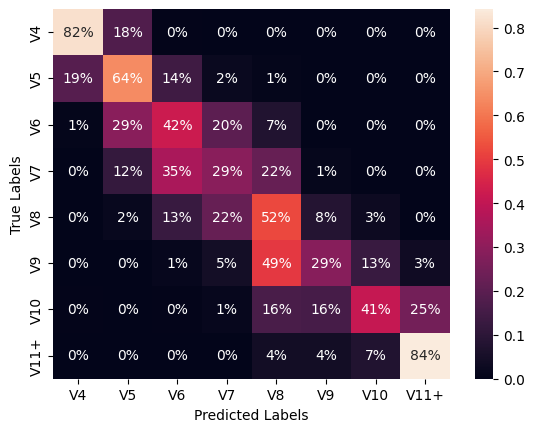

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt

ticklabels = ["V4", "V5", "V6", "V7", "V8", "V9", "V10", "V11+"]

# get train set stats
cf_matrix, auc, f1 = get_stats(model, train_iterator, device)
cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

print(f"Training set metrics:")
print(f"AUC Score: {auc:0.4f} | F1 Score: {f1:0.4f}")
ax = sns.heatmap(cf_matrix_norm, annot=True, fmt='.0%', xticklabels=ticklabels, yticklabels=ticklabels)
ax.set(xlabel="Predicted Labels", ylabel="True Labels")

Validation set metrics:
AUC Score: 0.7247 | F1 Score: 0.5578


[Text(0.5, 23.52222222222222, 'Predicted Labels'),
 Text(50.722222222222214, 0.5, 'True Labels')]

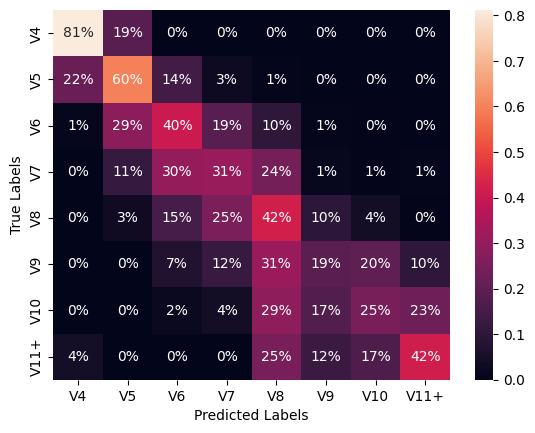

In [25]:
# get valid set stats
cf_matrix, auc, f1 = get_stats(model, valid_iterator, device)
cf_matrix_norm = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

print(f"Validation set metrics:")
print(f"AUC Score: {auc:0.4f} | F1 Score: {f1:0.4f}")
ax = sns.heatmap(cf_matrix_norm, annot=True, fmt='.0%', xticklabels=ticklabels, yticklabels=ticklabels)
ax.set(xlabel="Predicted Labels", ylabel="True Labels")